<a href="https://colab.research.google.com/github/pedramaghazadeh/Math-Lab-Project/blob/main/Math_Lab_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing useful libraries:

In [ ]:
import tensorflow as tf
import cv2
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from lxml import etree
import easyocr

Some incompatibility issues with opencv-python-headless after installing easyocr

In [ ]:
!pip install easyocr
!pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.1.2.30

Reading data and displaying pictures with plate borders

In [ ]:
imagedir = "../content/drive/MyDrive/Math Lab/data/images"
labeldir = "../content/drive/MyDrive/Math Lab/data/annotations"
images = []
labels = []
imageNames = []
labelNames = []

for name in os.listdir(imagedir):
    imageNames.append(f'{imagedir}/{name}')

imageNames = sorted(imageNames)

for name in imageNames:
    image = cv2.imread(name)
    image = np.asarray(image)
    images.append(np.asarray(image))
    

for name in os.listdir(labeldir):
    labelNames.append(f'{labeldir}/{name}')
labelNames = sorted(labelNames)

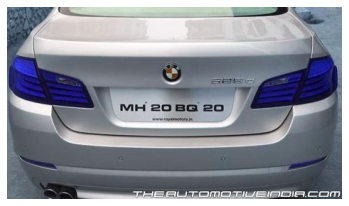

In [ ]:
image = images[10]
plt.axis("off")
plt.imshow(image)

Dataset sample

In [ ]:
for name in labelNames:
    tree = etree.parse(name)
    width = int(tree.xpath("size")[0].xpath("width")[0].text)
    height = int(tree.xpath("size")[0].xpath("height")[0].text)
    xmin = int(tree.xpath("object/bndbox")[0].xpath("xmin")[0].text) 
    ymin = int(tree.xpath("object/bndbox")[0].xpath("ymin")[0].text) 
    xmax = int(tree.xpath("object/bndbox")[0].xpath("xmax")[0].text) 
    ymax = int(tree.xpath("object/bndbox")[0].xpath("ymax")[0].text) 
    labels.append([int(xmin), int(ymin), int(xmax), int(ymax)])

[203, 193, 285, 229]


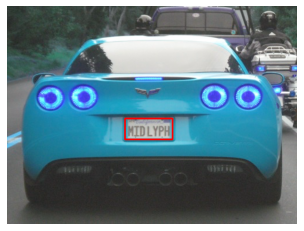

In [ ]:
ind = 290
plt.imshow(images[ind])
print(labels[ind])
image = cv2.rectangle(np.copy(images[ind]), (labels[ind][0], labels[ind][1]), 
                      (labels[ind][2], labels[ind][3]), (255, 0, 0), 2)
plt.axis("off")
plt.imshow(image)

Using contours for detecting plate characters without machine learning

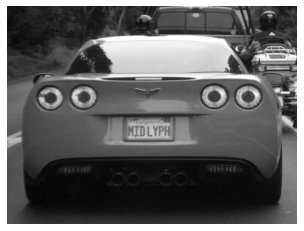

In [ ]:
img = np.copy(images[ind])
label = labels[ind]
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.axis("off")
plt.imshow(gray, cmap = "gray")

Increasing contrast of picture to detect edges better

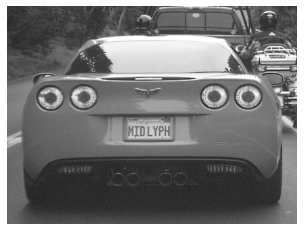

In [ ]:
structure_img = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)) 
#3*3 rectangle used as filter
imgTop = cv2.morphologyEx(gray , cv2.MORPH_TOPHAT, structure_img)
#It is the difference between input image and Opening of the image.
imgBlack = cv2.morphologyEx(gray , cv2.MORPH_BLACKHAT, structure_img) 
#It is the difference between the closing of the input image and input image.

gray = cv2.add(gray, imgTop)
gray = cv2.subtract(gray, imgBlack)
plt.axis("off")
plt.imshow(gray, cmap = "gray")

Using threshold on blurred photo

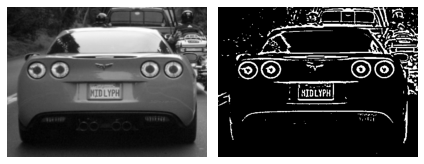

In [ ]:
blurred = cv2.GaussianBlur(gray, ksize = (5, 5), sigmaX = 0)
thresh = cv2.adaptiveThreshold(blurred, 
                               maxValue = 255,
                               adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               thresholdType = cv2.THRESH_BINARY_INV,
                               blockSize = 19,
                               C = 9)
plt.subplot(1, 2, 1)
plt.xlabel("Blurred")
plt.axis("off")
plt.imshow(blurred, cmap = "gray")

plt.subplot(1, 2, 2)
plt.xlabel("Threshold")
plt.axis("off")
plt.imshow(thresh, cmap = "gray")
plt.tight_layout()
plt.show()

Drawing contours

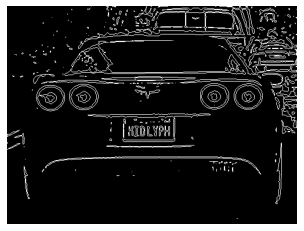

In [ ]:
contours, _= cv2.findContours(
    thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

height, width, channel = img.shape
result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(result, contours=contours, contourIdx=-1
                 , color=(255, 255, 255))
plt.axis("off")
plt.imshow(result)
plt.show()

Finding rectangles containing contours

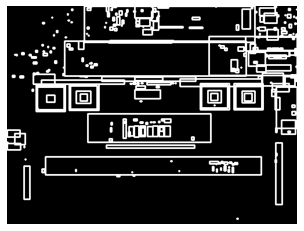

In [ ]:
result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(result, pt1=(x, y), pt2=(x+w, y+h)
                    , color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })
plt.axis("off")
plt.imshow(result, cmap = "gray")
plt.show()

Chossing rectangles that fit the size of plate characters !

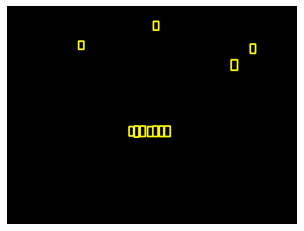

In [ ]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0
MAX_WIDTH, MAX_HEIGHT = 12, 20
possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if (area > MIN_AREA 
        and d['w'] > MIN_WIDTH 
        and d['h'] > MIN_HEIGHT 
        and MIN_RATIO < ratio < MAX_RATIO
        and d['w'] < MAX_WIDTH
        and d['h'] < MAX_HEIGHT):
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    cv2.rectangle(result, pt1=(d['x'], d['y'])
                  , pt2=(d['x']+d['w'], d['y']+d['h'])
                  , color=(255, 255, 0), thickness=2)

plt.imshow(result, cmap='gray')
plt.axis('off')
plt.show()

We filter most of bad rectangles !
Now it's time to find 7 characters next to each other!

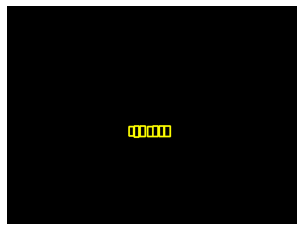

In [ ]:
final_contours = []
MIN_DIST = 120
for contour in possible_contours:
  for nearest_contour in possible_contours:
    x, y = contour['x'], contour['y']
    xx, yy = nearest_contour['x'], nearest_contour['y']
    if(0 < (x - xx) ** 2 + (y - yy) ** 2 < MIN_DIST):
      final_contours.append(contour)
      break

result = np.zeros((height, width, channel), dtype=np.uint8)

for d in final_contours:
    cv2.rectangle(result, pt1=(d['x'], d['y'])
                  , pt2=(d['x']+d['w'], d['y']+d['h'])
                  , color=(255, 255, 0), thickness=2)

plt.imshow(result, cmap='gray')
plt.axis('off')
plt.show()

Drawing them on the original picture !

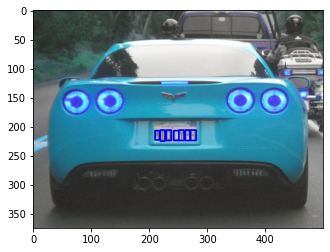

In [ ]:
for d in final_contours:
  cv2.rectangle(img, pt1=(d['x'], d['y'])
                , pt2=(d['x']+d['w'], d['y']+d['h'])
                , color=(0, 0, 255), thickness=2)

plt.imshow(img)
plt.show()

Sorting rectangles to detect the order of characters

242 207 9 17
210 207 8 16
271 206 10 18
262 206 8 18
251 206 9 18
229 206 9 18
219 206 8 19


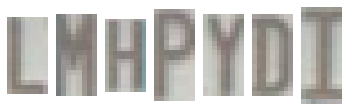

In [ ]:
img = images[ind]
lst = []
cnt = 1
MIN_X, MIN_Y = 1000, 1000
MAX_X, MAX_Y = -1, -1
for d in final_contours:
  print(d['x'], d['y'], d['w'], d['h'])
  cropped = images[ind][int(d['y']) : int(d['y'] + d['h'])
                      , int(d['x']) : int(d['x'] + d['w'])]
  MIN_X = min(MIN_X, d['x'])
  MAX_X = max(MAX_X, d['x'] + d['w'])
  MIN_Y = min(MIN_Y, d['y'])
  MAX_Y = max(MAX_Y, d['y'] + d['h'])


  lst.append((d['x'], cropped))
  plt.subplot(1, int(len(final_contours)), cnt)
  cnt += 1
  plt.imshow(cropped)
  plt.axis("off")
plt.show()


Now characters are sorted :D

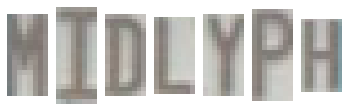

In [ ]:
lst = sorted(lst, key = lambda x : x[0])
for i in range(len(lst)):
  plt.subplot(1, 7, i + 1)
  plt.axis("off")
  plt.imshow(lst[i][1])
plt.show()

Using easyocr to detect characters
this is the only part we use machine learning in this method

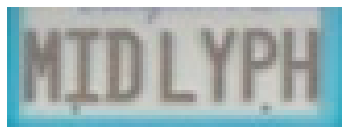

In [ ]:
MIN_Y -= 5
MIN_X -= 5
MAX_Y += 5
MAX_X += 5
img = images[ind][MIN_Y : MAX_Y, MIN_X : MAX_X]
plt.axis("off")
plt.imshow(img)


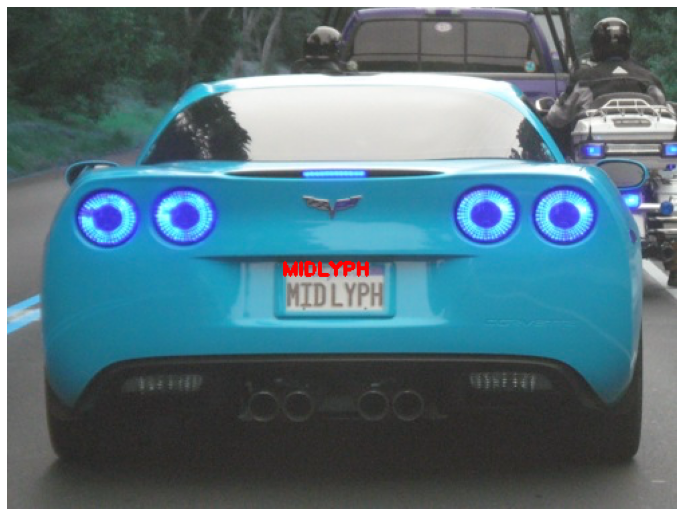

In [ ]:
text = easyocr.Reader(['en'])
ans = text.readtext(img, paragraph = "False")
img = np.copy(images[ind])

if(len(ans) > 0):
  cv2.putText(img, ans[0][1], (MIN_X, MIN_Y), cv2.FONT_HERSHEY_PLAIN, 1, 
              (255, 0, 0), 2)
plt.figure(figsize=(12, 10))
plt.axis("off")
plt.imshow(img)

Now lets try something new!

A general model to detect plates.

In [ ]:
imagedir = "../content/drive/MyDrive/Math Lab/data/images"
labeldir = "../content/drive/MyDrive/Math Lab/data/annotations"
images = []
labels = []
imageNames = []
labelNames = []

for name in os.listdir(imagedir):
    imageNames.append(f'{imagedir}/{name}')

imageNames = sorted(imageNames)

for name in imageNames:
    image = cv2.imread(name)
    image = cv2.resize(image, (200, 200))
    image = np.asarray(image)
    images.append(np.asarray(image))
    

for name in os.listdir(labeldir):
    labelNames.append(f'{labeldir}/{name}')
labelNames = sorted(labelNames)

for name in labelNames:
    tree = etree.parse(name)
    width = int(tree.xpath("size")[0].xpath("width")[0].text)
    height = int(tree.xpath("size")[0].xpath("height")[0].text)
    xmin = int(tree.xpath("object/bndbox")[0].xpath("xmin")[0].text) * (200 / width)
    ymin = int(tree.xpath("object/bndbox")[0].xpath("ymin")[0].text) * (200 / height)
    xmax = int(tree.xpath("object/bndbox")[0].xpath("xmax")[0].text) * (200 / width)
    ymax = int(tree.xpath("object/bndbox")[0].xpath("ymax")[0].text) * (200 / height)
    labels.append([int(xmin), int(ymin), int(xmax), int(ymax)])

Normalizing vectors

In [ ]:
images = np.asarray(images)
labels = np.asarray(labels)
images = images / 255
labels = labels / 255

Splitting data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels
                                                    , train_size = 0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train
                                                                , y_train
                                                                , test_size = 0.1
                                                                , random_state = 0)

Importing model

In [ ]:
from keras.models import Sequential #Model is sequential
from keras.layers import Dense, Flatten #Dense for each layer, Flatten for linear
from keras.applications.vgg16 import VGG16 #Image classifier model

**include_top**: whether to include the 3 fully-connected layers at the top of the network.

**weights**: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.

**input_shape** : pretty obvious :D

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(VGG16(include_top = False, weights = "imagenet"
          , input_shape = images[0].shape))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(256, activation = "relu"))
model.add(Dense(128, activation = "relu"))
model.add(Dense(4, activation = "sigmoid")) #Output layer

model.layers[-6].trainable = False #Decreasing trainable params

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 19,532,740
Trainable params: 4,818,052
Non

In [ ]:
model.compile(loss = "mean_squared_error", optimizer = "adam"
              , metrics = ["accuracy"])
trained_model = model.fit(X_train, y_train, batch_size = 32, epochs = 20
                          , verbose = 1
                          , validation_data = (X_validation, y_validation))

Epoch 1/20
3/3 [==============================] - 1s 225ms/step - loss: 0.0760 - accuracy: 0.2597 - val_loss: 0.0914 - val_accuracy: 0.2222
Epoch 2/20
3/3 [==============================] - 0s 110ms/step - loss: 0.0673 - accuracy: 0.4545 - val_loss: 0.0387 - val_accuracy: 0.1111
Epoch 3/20
3/3 [==============================] - 0s 112ms/step - loss: 0.0445 - accuracy: 0.3377 - val_loss: 0.0303 - val_accuracy: 0.7778
Epoch 4/20
3/3 [==============================] - 0s 113ms/step - loss: 0.0379 - accuracy: 0.6623 - val_loss: 0.0297 - val_accuracy: 0.7778
Epoch 5/20
3/3 [==============================] - 0s 113ms/step - loss: 0.0332 - accuracy: 0.6364 - val_loss: 0.0294 - val_accuracy: 0.6667
Epoch 6/20
3/3 [==============================] - 0s 115ms/step - loss: 0.0297 - accuracy: 0.7922 - val_loss: 0.0300 - val_accuracy: 0.8889
Epoch 7/20
3/3 [==============================] - 0s 111ms/step - loss: 0.0272 - accuracy: 0.7922 - val_loss: 0.0325 - val_accuracy: 0.5556
Epoch 8/20
3/3 [====

verbose: 'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

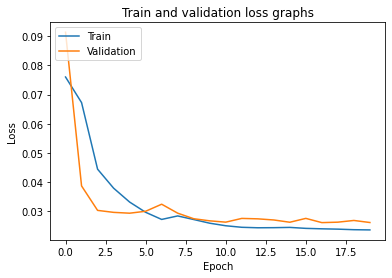

In [ ]:
plt.plot(trained_model.history["loss"])
plt.plot(trained_model.history["val_loss"])
plt.title("Train and validation loss graphs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

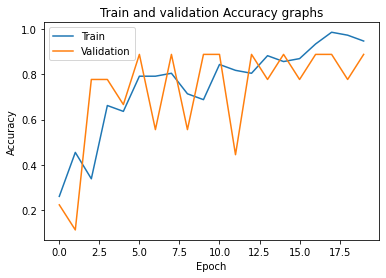

In [ ]:
plt.plot(trained_model.history["accuracy"])
plt.plot(trained_model.history["val_accuracy"])
plt.title("Train and validation Accuracy graphs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

In [ ]:
text = easyocr.Reader(['en'])

In [ ]:
y_cnn = model.predict(X_test)

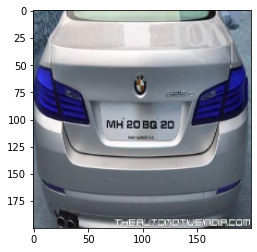

In [ ]:
ind = 80
plt.imshow(X_test[ind])

[[[[65, 5], [133, 5], [133, 19], [65, 19]], 'Mh2o80 20']]


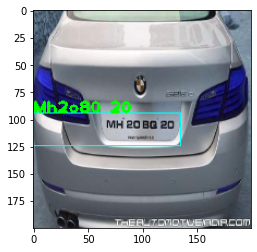

In [ ]:

y = np.copy(y_cnn[ind])
y = y * 255

cropped = X_test[ind][int(y[1]) : int(y[3]), int(y[0]) : int(y[2])]

cropped = (cropped * 255).astype("uint8")

result = text.readtext(cropped, paragraph = "False")

img = cv2.rectangle(np.copy(X_test[ind]  * 255).astype("uint8"), 
                    (int(y[0]), int(y[1])), 
                    (int(y[2]), int(y[3])), (0, 255, 255), 1)
print(result)
if(len(result) > 0):
  cv2.putText(img, result[0][1], (int(y[0]), int(y[1])), cv2.FONT_HERSHEY_PLAIN,
              1, (0, 255, 0), 2)

plt.imshow(img)
plt.show()